## Analysis of A/B Test Results of an E-Commerce Company Website followed by recommendations.


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The E-commerce company had developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. The goal is to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision.



<a id='probability'></a>
#### Part I - Probability

To get started, I'll be importing the required libraries

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [3]:
# stores the respective csv file in a designated data frame 
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# returns the total number of rows in the data frame
print("Number of rows:"+ str(df.shape[0]))

Number of rows:294478


In [5]:
# returns the number of unique users in the data set using the nunique() function
print('Number of unique users in the dataset are:'+ str(df['user_id'].nunique()))

Number of unique users in the dataset are:290584


In [6]:
#  returns the value of the proportion of users represented as 'converted'
total_rows=(df.shape[0])
proportion=sum(df['converted'].values)/total_rows
print('The proportion of users converted are: '+ str((proportion*100).round(2))+'%')

The proportion of users converted are: 11.97%


Evaluating the number of times the `new_page` and `treatment` don't line up.

In [7]:
# creates a variable which holds the first mismatched pair  
mismatch_pair1= df.query("group == 'treatment' and landing_page == 'old_page'")

# creates a variable which holds the second mismatched pair
mismatch_pair2= df.query("group == 'control' and landing_page == 'new_page'")

#  prints the number of times the new_page and treatment don't line up 
print("The number of times the new_page and treatment don't line up is {}".format(len(mismatch_pair1) + len(mismatch_pair2)))

The number of times the new_page and treatment don't line up is 3893


Missing values check 

In [8]:
# returns a quick overview of the data contained in the data frame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


 * Observing the the data above we can see that there are no missing/null values in any fields.


For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Hence, moving forward with the analysis.

Storing new dataframe in **df2**.

In [9]:
# trimming the original dataset by deleting entries where group & landing page is treatment and old page respectively

df.drop(df.query("group == 'treatment' and landing_page == 'old_page'").index, inplace=True)

df.drop(df.query("group == 'control' and landing_page == 'new_page'").index, inplace=True)

In [10]:
# saves the newly trimmed dataset as ab_new
df.to_csv('ab_new.csv')

In [11]:
# loads the dataset into a new data frame (df2)
df2=pd.read_csv('ab_new.csv')

In [12]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Identifying how many unique **user_id**s are in **df2**?

In [13]:
#returns the unique number of user_ids
print('There are ' + str(len(df2['user_id'].unique())) + ' unique user_ids in df2')

There are 290584 unique user_ids in df2


Identifying one **user_id** repeated in **df2**.  

In [14]:
#filters out the duplicate entry 
df2[df2.duplicated(['user_id'], keep=False)]

,Unnamed: 0,user_id,timestamp,group,landing_page,converted
1876,1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


* As seen above user_id 773192 is repeated in df 2 

Row information for the repeat **user_id**


In [15]:
df2[df2.duplicated(['user_id'], keep=False)]

,Unnamed: 0,user_id,timestamp,group,landing_page,converted
1876,1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2862,2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing **one** of the rows with a duplicate **user_id**

In [16]:
# deleting the entry where timestamp is 2017-01-14 02:55:59.590927'
df2 = df2[df2.timestamp != '2017-01-14 02:55:59.590927']

In [17]:
# confirming duplicate deletion
df2[df2.duplicated(['user_id'], keep=False)]

,Unnamed: 0,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [18]:
# the probability of converting will be equal to the mean of the the 'converted' column as there are only 1 and 0 values as entries
print('The probablity of an individual converting regardless of the page they receive is '+ str(int(df['converted'].mean().round(2)*100))+'%')

The probablity of an individual converting regardless of the page they receive is 12%


b. Given that an individual was in the `control` group, what is the probability they converted?

In [19]:
# grouping by 'group' field to calculate aggregated statistics 
df_grouped=df.groupby('group')
df_grouped.describe()

converted                                                user_id  \
              count      mean       std  min  25%  50%  75%  max     count   
group                                                                        
control    145274.0  0.120386  0.325414  0.0  0.0  0.0  0.0  1.0  145274.0   
treatment  145311.0  0.118807  0.323563  0.0  0.0  0.0  0.0  1.0  145311.0   

                                                                      \
                    mean           std       min       25%       50%   
group                                                                  
control    788164.072594  91287.914601  630002.0  709279.5  788128.5   
treatment  787845.618446  91161.258854  630000.0  708746.5  787874.0   

                                
                 75%       max  
group                           
control    867208.25  945998.0  
treatment  866718.50  945999.0

* The probability of an individual given that he was in the control group is 12.03%.

c. Given that an individual was in the `treatment` group, what is the probability they converted?

* The probability of an individual given that he was in the treatment group is 11.8%.

d. What is the probability that an individual received the new page?

In [20]:
# users in the treatment group correspond to users who got the new page, 
#hence finding no. of users with the 'grouped' labelled as treatment and dividing by the total no. of user rows
#gives us the required probability
new_user = len(df.query("group == 'treatment'"))
users=df.shape[0]
print('The probability that an individual received the new page is '+str(int((new_user/users)*100))+'%')

The probability that an individual received the new page is 50%


* Companring the means of the control and treatment group we notice that the difference between the means is very less, implying that there isn't strong evidence to state whether one page leads to more conversions than the other.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, one could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is does one stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long does one run the test to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I'm considering to make the decision just based on all the data available.  

* $H_{0}$: $p_{old}$ >=  $p_{new}$
* $H_{1}$: $p_{old}$ <  $p_{new}$

`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Using a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>



Evaluating the **convert rate** for $p_{new}$ under the null 

In [21]:
p_new = df2['converted'].mean().round(2)
print(p_new)

0.12


Evaluating the **convert rate** for $p_{old}$ under the null <br><br>

In [22]:
p_old = df2['converted'].mean().round(2)
print(p_old)

0.12


Evaluating  $n_{new}$

In [23]:
n_new = len(df2.query("group == 'treatment'"))
print(n_new)

145310


d. What is $n_{old}$?

In [24]:
n_old = len(df2.query("group == 'control'"))
print(n_old)


145274


Simulating $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Storing these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:

new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])


Simulating $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Storing these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])

Finding $p_{new}$ - $p_{old}$ for the simulated values from part (e) and (f).

In [27]:
# We cannot calculate p_new-p_old as new_page_converted and old_page_converted have different sizes
# eliminating excess entries in new_page_converted we get the following
new_page_converted = new_page_converted[:145274]
p_diff = (new_page_converted/n_new) - (old_page_converted/n_old)

Simulating 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Storing all 10,000 values in **p_diffs**.

In [28]:
p_diffs = []

for i in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)]).mean()
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)]).mean()
    diff = new_page_converted - old_page_converted 
    p_diffs.append(diff)

Ploting a histogram of the **p_diffs**.  

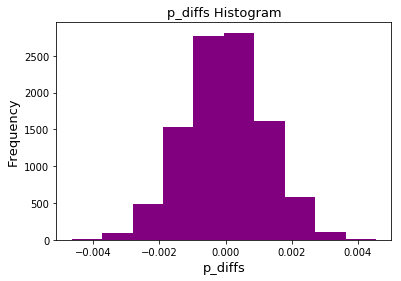

In [29]:
plt.hist(p_diffs,color='purple')
plt.xlabel('p_diffs',fontsize=13)
plt.ylabel('Frequency',fontsize=13)
plt.title('p_diffs Histogram',fontsize=13);

Evaluating What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**

In [30]:
#calculating the difference from the original dataset 'ab_data.csv'
actual_diff = df[df['group'] == 'treatment']['converted'].mean() -  df[df['group'] == 'control']['converted'].mean()
actual_diff

-0.0015790565976871451

In [31]:
p_diffs = np.array(p_diffs)
p_diffs

array([-0.00072475,  0.00046584, -0.00032565, ...,  0.00029366,
        0.00257896,  0.00096811])

In [32]:
((actual_diff < p_diffs).mean()).round(2)

0.90000000000000002

* The value computed in part j is known as the p-value.
* This value signifies the correctness of the null hypothesis.
* As per convention a smaller P-value is an indicator that the null hypothesis is false but in this case the p-value 0.91 is way larger as compared to 0.05 (p-crtitical) and hence we accept the null hypothesis.
* In this case, the null hypothesis is true as there is no significant difference between the performance of the old and new pages.

We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [33]:
import statsmodels.api as sm

convert_old = sum(df2.query("group == 'control'")['converted'])
convert_new = sum(df2.query("group == 'treatment'")['converted'])
n_old = len(df2.query("group == 'control'"))
n_new = len(df2.query("group == 'treatment'"))

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Using `stats.proportions_ztest` to compute test statistic and p-value.

In [34]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
print(z_score.round(2), p_value.round(2))

1.31 0.91


In [35]:
# importing required modules to compute the significane of the z-score
# default 95% C.I
from scipy.stats import norm

print(norm.cdf(z_score).round(2))
print(norm.ppf(1-(0.05)).round(2))


0.91
1.64


* Observing the values computed from the cells above we see that the critical value of 1.6 is > than the z-score of 1.31.
* Hence, we accept the null hypothesis 
* There is no significant difference between the conversion rates of the old and new pages but the old pages perform better than the new pages.
* Yes the values agree to the findings in parts j and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, I will check if the results acheived in the previous A/B test can also be acheived by performing regression.<br><br>

Since each row is either a conversion or no conversion

* Logistic Regression is used to predict either of the two outcomes ( conversion or no conversion)

The goal is to use **statsmodels** to fit the regression model specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, first there's a need to create a column for the intercept, and to create a dummy variable column for which page each user received.  Adding an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
df2['intercept']=1
df2[['control', 'ab_page']]=pd.get_dummies(df2['group'])
df2.drop(labels=['control'], axis=1, inplace=True)
df2.head()

,Unnamed: 0,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


Using **statsmodels** to import the regression model.  Instantiating the model, and fiting the model using the two columns created in part **b.** to predict whether or not an individual converts.

In [37]:
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page',]])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


In [38]:

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:               8.077e-06
Time:                        02:55:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Evaluating What is the p-value associated with **ab_page** and Why does it differ from the value found in the **Part II**?<br><br>  

* As seen in output cell 37 above the p- value associated with the ab_page (treatment) is 0.19 > 0.05. 
* It differs from the value in part 2 because it was a one sided test and this one is a 2 sided test. 
* Also, the values are different because in part 2 we randomly sampled the data 10000 times and the sample could have overlapped or migh have been mutually exclusive to an extent to give different values such that differet p-values were received than what we got in logistic regression.

Now, considering other things that might influence whether or not an individual converts.  Evaluating why it is a good idea to consider other factors to add into the regression model.  Are there any disadvantages to adding additional terms into your regression model?

* In addition to current considerations additional factors influencing conversion rates might be useful in developing a more refined model ( improved accuracy,reliability) as it would account more predictor variables giving a deeper picture of an individual or target segment. 
* Additional factors such as device used, age, time of year (special occasions) might influence conversion rate. Considering these factors would be helpful in narrowing on the type of users and their usage patterns which eventually will help in better predicting newer users of similar characterisitcs.
* The caveats to adding additional terms into the model would be variance,multi-collinearity,model complexity.

Along with testing if the conversion rate changes for different pages, adding an effect based on which country a user lives. 

Evaluating if country had an impact on conversion. Followed by creating dummy variables.

In [39]:
# joining data frames with index 'user_id'
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner') 
df_new.head()


,country,Unnamed: 0,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [40]:
#creating new dummy variables
df_new[['CA','UK','US']]=pd.get_dummies(df_new['country'])
df_new.head()

,country,Unnamed: 0,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,,
834778,UK,143206,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,157345,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,257177,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,48778,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,106686,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [41]:
mod = sm.Logit(df_new['converted'], df_new[['intercept', 'CA', 'US']])
results = mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:               1.521e-05
Time:                        02:55:27   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9868      0.011   -174.174      0.000      -2.009      -1.964
CA            -0.0507      0.028     -1.786      0.074      -0.106       0.005
US            -0.0099      0.013     -0.746      0.456      -0.036       0.016
==============================================================================
"""

Though I've looked at the individual factors of country and page on conversion, I'd now like to look at an interaction between page and country to see if there significant effects on conversion.  Creating the necessary additional columns to fit the new model.  

Providing the summary results

In [42]:
# summary display
log_mod = sm.Logit(df_new['converted'], df_new[['intercept','CA', 'US','ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 27 Jun 2018   Pseudo R-squ.:               2.323e-05
Time:                        02:55:28   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9794      0.013   -155.415      0.000      -2.004      -1.954
CA            -0.0506      0.028     -1.784      0.074      -0.106       0.005
US            -0.0099      0.013     -0.743      0.457      -0.036       0.016
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

In [43]:
df.groupby('group').mean()['converted']

group
control      0.120386
treatment    0.118807
Name: converted, dtype: float64

In [45]:
df_new['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

## Conclusions 

* From the regression model we observe that the p-value for ab_page is 0.19 which is way higher than the p-critical value 0f 0.05 implying that the results are no statistically significant.
* All of the p values for the countries 0.074,0.457 and the ab_page p value 0.19 are above the threshold meaning there is no significant influencing impact on conversion rates.
* The team should finalize on not implementing the new page as there is no significant statistical evidence for improved conversion rate upon implementation.

## Resources


* Stack overflow
